# SOCIAL SURVEY PROJECT

In [6]:
import pandas as pd
import seaborn as sns
import pyreadstat
from urllib import request
from zipfile import ZipFile
import requests

#### Download the zip file for the social survey

In [9]:
zip_url = 'http://gss.norc.org/Documents/stata/gss_stata_with_codebook.zip'
response = requests.get(zip_url)

In [12]:
if response.status_code == 200:
    with open('gss_stata_with_codebook.zip', 'wb')  as file:
        file.write(response.content)
else:
    print('Fail to download the file, HTTP status code: ', response.status_code)

#### Unzip the file

In [15]:
with ZipFile('gss_stata_with_codebook.zip', mode= 'r') as zip:
    zip.extractall()
    for file in zip.infolist():
        print(f'{file.filename:25}-{file.file_size:15,d} Bytes')

Release Notes 7218.pdf   -        296,746 Bytes
GSS_Codebook.pdf         -     37,952,897 Bytes
GSS7218_R3.DTA           -    449,140,819 Bytes


#### Extract the metadata using the pyreadstat module

In [16]:
gss_empty, gss_meta = pyreadstat.read_dta('GSS7218_R3.DTA', metadataonly= True)
print('Number of columns: ', gss_meta.number_columns)
print('Number of rows: ', gss_meta.number_rows)

Number of columns:  6110
Number of rows:  64814


#### Build a DataFrame of column names and descriptions

In [17]:
meta_cols = pd.DataFrame(data=gss_meta.column_labels,
                         index= gss_meta.column_names,
                         columns=['description'])
meta_cols

,description
year,gss year for this respondent
id,respondent id number
wrkstat,labor force status
hrs1,number of hours worked last week
hrs2,number of hours usually work a week
...,...
wtss,weight variable
wtssnr,weight variable
wtssall,weight variable
vstrat,variance stratum


#### Load the data for the wrkstat question into a DataFrame

In [18]:
workStatus = pd.read_stata('GSS7218_R3.DTA', columns= ['id', 'year', 'wrkstat'])
workStatus.head()

,id,year,wrkstat
0,1,1972,working fulltime
1,2,1972,retired
2,3,1972,working parttime
3,4,1972,working fulltime
4,5,1972,keeping house


## Prepare the data
The first goal for the analysis of the wrkstat data is to identify when major changes in employment status has occured.

In [19]:
#View the data types of the columns
workStatus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64814 entries, 0 to 64813
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       64814 non-null  int16   
 1   year     64814 non-null  int16   
 2   wrkstat  64793 non-null  category
dtypes: category(1), int16(2)
memory usage: 317.0 KB


In [20]:
#Check the work status data for missing responses
workStatus['wrkstat'].value_counts(dropna= False)

wrkstat
working fulltime    31892
keeping house       10176
retired              9121
working parttime     6719
unempl, laid off     2179
school               1998
temp not working     1363
other                1345
NaN                    21
Name: count, dtype: int64

As a result, there is only 21 missing values, so we can safely ignore the rows with those values since there are so few relative to the number of responses.

In [21]:
#Add counts by year
statusCounts = workStatus.groupby(by=['year', 'wrkstat'], as_index= False).count()
statusCounts.columns = ['year', 'wrkstat', 'counts']
statusCounts.head()

,year,wrkstat,counts
0,1972,working fulltime,750
1,1972,working parttime,121
2,1972,temp not working,38
3,1972,"unempl, laid off",46
4,1972,retired,144


### Plot the data and reduce the number of categories

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


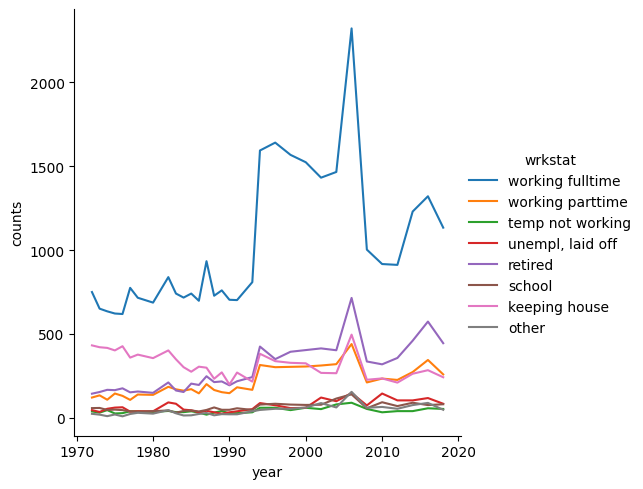

In [22]:
#Plot the wrkstat data
sns.relplot(data= statusCounts, x= 'year', y='counts', hue = 'wrkstat', kind= 'line')

As we can see, the plot lines at the bottom of the chart run together, so the plot is difficult to read. To fix the problem, we narrow down the data to just three or four of the categories.

We will filter the data to just 4 categories: working fulltime, working parttime, retired, and umemployed or laid off.

In [23]:
#Reduce the number of plotted categories
statusCountsTop = statusCounts.query(
    'wrkstat in ["working fulltime", "working parttime", "retired", "unempl, laid off"]').copy()

In [30]:
#The categories after filtering
statusCountsTop.wrkstat.value_counts()

wrkstat
working fulltime    32
working parttime    32
unempl, laid off    32
retired             32
Name: count, dtype: int64

In [26]:
#Remove unused categories
statusCountsTop.wrkstat = statusCountsTop.wrkstat.cat.remove_unused_categories()
statusCountsTop.wrkstat.value_counts()

wrkstat
working fulltime    32
working parttime    32
unempl, laid off    32
retired             32
Name: count, dtype: int64

In [33]:
statusCountsTop.head()

,year,wrkstat,counts
0,1972,working fulltime,750
1,1972,working parttime,121
3,1972,"unempl, laid off",46
4,1972,retired,144
8,1973,working fulltime,651


#### Plot the total counts of the responses

When the surveys are repeated year after year, the number of yearly responses often fluctuates, which can cause problem if the trendlines represent the change in the total count more than the change in the ratio between the responses. One way to confirm this suspicion is to plot the total counts of the responses by year

In [35]:
#Count the total number of responses by year
topCountsByYear = statusCountsTop.groupby(by= ['year'], as_index= False)['counts'].sum()
topCountsByYear.head()

,year,counts
0,1972,1061
1,1973,974
2,1974,964
3,1975,993
4,1976,989


In [41]:
#Merge the topCountsByYear df with the topCounts df
topCounts = statusCountsTop.merge(topCountsByYear, on = 'year', suffixes= ('', 'Total'))
topCounts.head(20)

,year,wrkstat,counts,countsTotal
0,1972,working fulltime,750,1061
1,1972,working parttime,121,1061
2,1972,"unempl, laid off",46,1061
3,1972,retired,144,1061
4,1973,working fulltime,651,974
5,1973,working parttime,134,974
6,1973,"unempl, laid off",35,974
7,1973,retired,154,974
8,1974,working fulltime,635,964
9,1974,working parttime,108,964


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


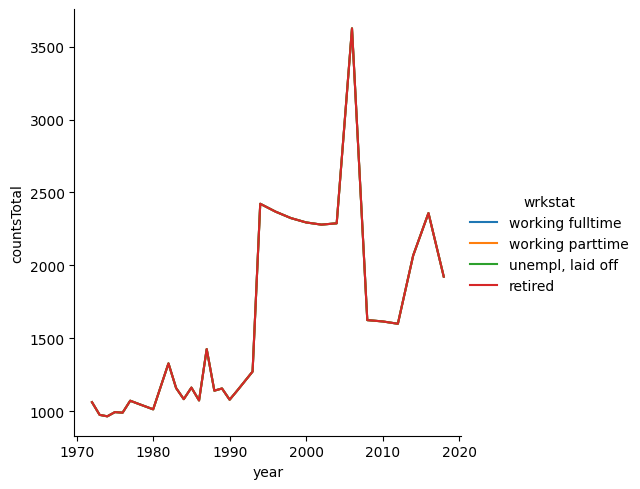

In [40]:
#Plot the data
sns.relplot(data = topCounts, x = 'year', y = 'countsTotal', hue = 'wrkstat', kind= 'line')

As a result, the line of all four categories colapsed because they are all the same. This mean that the trends of the lines in figure 14-4 are due more to the changes in the total number of respondents than to the changes in the responses to the question.

#### Convert the counts to percents and plot them

In [38]:
#Convert each measurement to a percentage of the total
topCounts['percent'] = topCounts.counts / topCounts.countsTotal
topCounts.head()

,year,wrkstat,counts,countsTotal,percent
0,1972,working fulltime,750,1061,0.706880
1,1972,working parttime,121,1061,0.114043
2,1972,"unempl, laid off",46,1061,0.043355
3,1972,retired,144,1061,0.135721
4,1973,working fulltime,651,974,0.668378


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


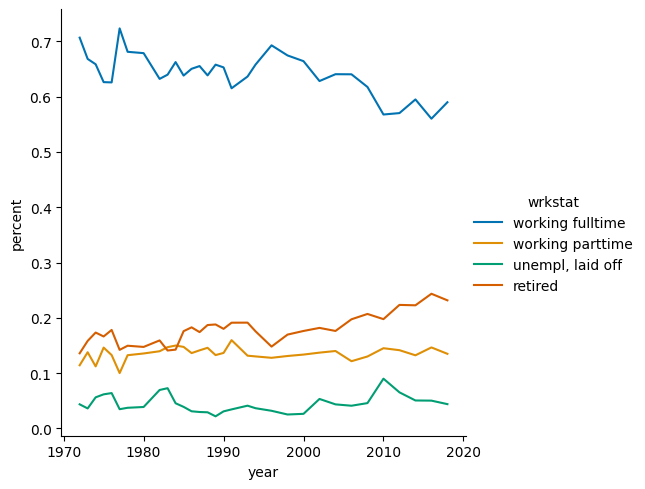

In [39]:
#Plot the percentage data
sns.relplot(data = topCounts, x = 'year', y = 'percent', kind = 'line', hue = 'wrkstat', palette= 'colorblind')

The lines plot the percentage instead of the counts. As a results, the new plot accurately identifies some trends. First, the percent of people working full-time has been declining. Second, the percent of retired people has been rising. Third, the percent of people who are unemployed, laid off, or working part-time has stayed about the same.

## The work-life balance data

#### Read and review the work-life data

In [42]:
#Read the work-life balance data
wlBalanceCols = ['wkcontct', 'talkspvs', 'effctsup']
wlBalance = pd.read_stata('GSS7218_R3.DTA', columns= wlBalanceCols).dropna()
wlBalance

,wkcontct,talkspvs,effctsup
57062,once or twice a month,very,very
57064,never,very,very
57074,never,very,somewhat
57079,never,somewhat,very
57081,never,very,very
...,...,...,...
59591,once or twice a month,somewhat,somewhat
59595,less than once a month,very,very
59596,never,somewhat,somewhat
59597,once or twice a month,a little,somewhat


In [44]:
#Identify the response values for each question
wlBalance.wkcontct.value_counts()

wkcontct
never                      329
less than once a month     187
once or twice a month      170
several times a week       145
once a week                 98
two or more times a day     42
once a day                  29
Name: count, dtype: int64

In [46]:
wlBalance.talkspvs.value_counts()

talkspvs
very                      333
somewhat                  259
extremely                 165
not at all comfortable    127
a little                  116
Name: count, dtype: int64

In [47]:
wlBalance.effctsup.value_counts()

effctsup
very                    338
somewhat                287
a little                158
extremely               125
not at all effective     92
Name: count, dtype: int64

#### Plot the responses for the first question

In [48]:
#Prepare the data for the wkcontct question
workContact = wlBalance.wkcontct.value_counts().to_frame().reset_index()
workContact.columns = ['answer', 'count']
workContact

,answer,count
0,never,329
1,less than once a month,187
2,once or twice a month,170
3,several times a week,145
4,once a week,98
5,two or more times a day,42
6,once a day,29


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


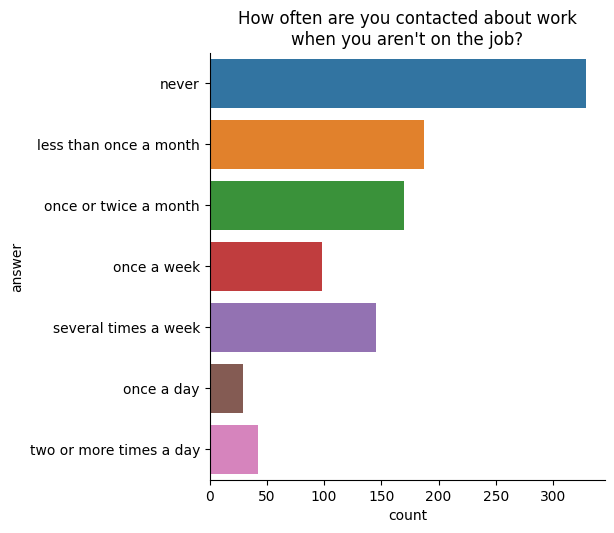

In [50]:
#Plot the data for the wkcontct question
g = sns.catplot(data= workContact, x= 'count', y = 'answer',
                kind = 'bar', orient= 'h', aspect= 1.25)
g.set(title = "How often are you contacted about work\n" +
                "when you aren't on the job?")

As a result, a relatively low number of people are contacted about work more than once a week when they aren't on the job.

Note: Since both the talkspvs and effctsup columns have 5 category values that are almost the same, these column can be plot together. We have to plot the wkcontct column on its own since its category values are different.



#### Plot the responses for the second and third question

In [51]:
#Prepare the data for plotting
#Create DataFrames for the second and third questions
df1 = wlBalance.talkspvs.value_counts().to_frame()
df1 = df1.rename(index={'not at all comfortable': 'not at all'})

df2 = wlBalance.effctsup.value_counts().to_frame()
df2 = df2.rename(index= {'not at all effective': 'not at all'})

,count
talkspvs,
very,333
somewhat,259
extremely,165
not at all,127
a little,116


In [57]:
#Join the DataFrames
supervisorData = df1.join(df2, lsuffix='_df1', rsuffix='_df2').reset_index()
supervisorData = supervisorData.rename(columns= {'talkspvs': 'index', 'count_df1': 'talkspvs', 'count_df2': 'effctsup'})
supervisorData.head()


,index,talkspvs,effctsup
0,very,333,338
1,somewhat,259,287
2,extremely,165,125
3,not at all,127,92
4,a little,116,158


In [58]:
#Melt the data in the combined DataFrame
supervisorData = pd.melt(supervisorData, id_vars= 'index', 
                         value_vars= ['talkspvs', 'effctsup'])
supervisorData.columns = ['answer', 'question', 'responseCount']

In [59]:
supervisorData.head()

,answer,question,responseCount
0,very,talkspvs,333
1,somewhat,talkspvs,259
2,extremely,talkspvs,165
3,not at all,talkspvs,127
4,a little,talkspvs,116


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


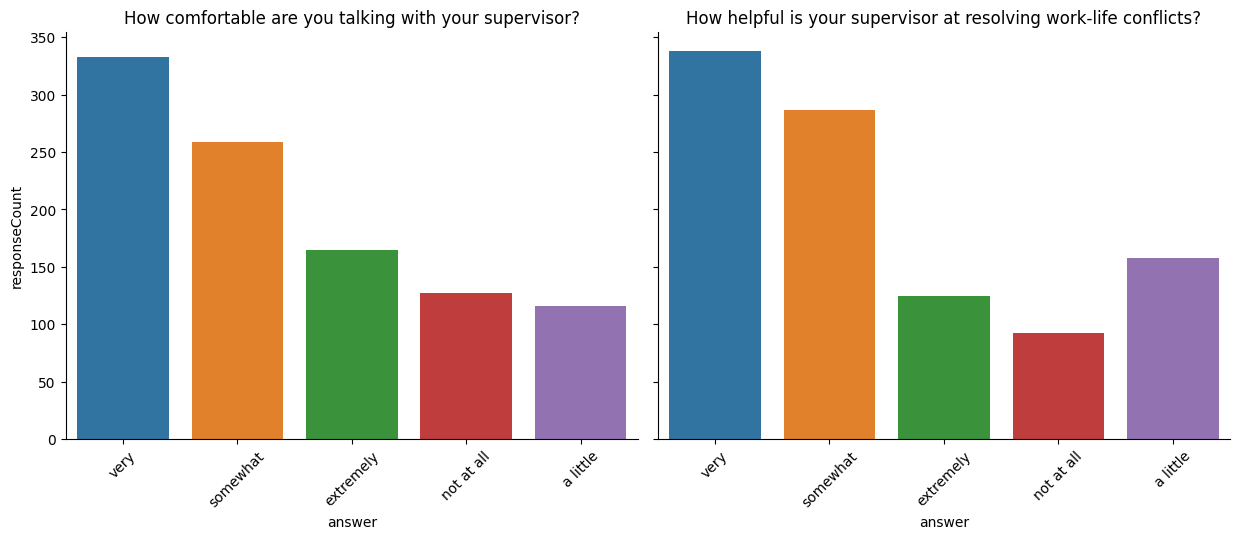

In [60]:
#Plot the data for the questions
g = sns.catplot(data = supervisorData, x= 'answer', y = 'responseCount',
                kind = 'bar', col = 'question', aspect= 1.25, col_wrap= 2)

titles = ['How comfortable are you talking with your supervisor?',
          'How helpful is your supervisor at resolving work-life conflicts?']

for i, ax in enumerate(g.axes.flat):
    ax.tick_params('x', labelrotation = 45)
    ax.set_title(titles[i])

## Expand the scope of the analysis

We will expand the scope of the analysis by combining survey data with demographic data like gender, race, and location.

In [68]:
#Read the entire dataset and find the columns with no missing values
allData = pd.read_stata('GSS7218_R3.DTA')

ValueError: 
Value labels for column impthngs are not unique. These cannot be converted to
pandas categoricals.

Either read the file with `convert_categoricals` set to False or use the
low level interface in `StataReader` to separately read the values and the
value_labels.

The repeated labels are:
--------------------------------------------------------------------------------
strongly disagree
